In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from sklearn.neighbors import RadiusNeighborsTransformer
from STEM.model import *
from STEM.utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.figdir = '../result_revise_TSK/'

In [3]:
scadata = sc.read_h5ad('cSCC/processed/scP2.h5ad')
stadata = sc.read_h5ad('cSCC/processed/stP2.h5ad')

sc.pp.normalize_total(scadata)
sc.pp.log1p(scadata)

sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)

scdata = pd.DataFrame(scadata.X,index=scadata.obs_names,columns=scadata.var_names)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

In [4]:
stadata2 = sc.read_h5ad('cSCC/processed/stP2rep2.h5ad')
sc.pp.normalize_total(stadata2)
sc.pp.log1p(stadata2)
stdata2 = pd.DataFrame(stadata2.X,index=stadata2.obs_names,columns=stadata2.var_names)

stadata3 = sc.read_h5ad('cSCC/processed/stP2rep3.h5ad')
sc.pp.normalize_total(stadata3)
sc.pp.log1p(stadata3)
stdata3 = pd.DataFrame(stadata3.X,index=stadata3.obs_names,columns=stadata3.var_names)

In [5]:
scadata.obs['rough_celltype'] =scadata.obs['level1_celltype'].astype(str)
scadata.obs.loc[scadata.obs['level1_celltype']=='CLEC9A','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='CD1C','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='ASDC','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='PDC','rough_celltype'] = 'PDC'
scadata.obs.loc[scadata.obs['level1_celltype']=='MDSC','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='LC','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='Mac','rough_celltype'] = 'Myeloid cell'
scadata.obs.loc[scadata.obs['level1_celltype']=='Tcell','rough_celltype'] = 'T cell'
scadata.obs.loc[scadata.obs['level2_celltype']=='TSK','rough_celltype'] = 'TSK'
scadata.obs.loc[scadata.obs['level2_celltype'].isin(['Tumor_KC_Basal', 'Tumor_KC_Diff','Tumor_KC_Cyc']),'rough_celltype'] = 'NonTSK'

In [6]:
scadata.obs.rough_celltype.value_counts()

DC                  885
NonTSK              608
Epithelial          597
Myeloid cell        255
PDC                 106
T cell               82
Endothelial Cell     73
TSK                  32
Fibroblast           22
Melanocyte           20
B Cell                5
NK                    3
Name: rough_celltype, dtype: int64

In [39]:
scadata.obs.rough_celltype.value_counts() / scadata.shape[0]

DC                  0.329241
NonTSK              0.226190
Epithelial          0.222098
Myeloid cell        0.094866
PDC                 0.039435
T cell              0.030506
Endothelial Cell    0.027158
TSK                 0.011905
Fibroblast          0.008185
Melanocyte          0.007440
B Cell              0.001860
NK                  0.001116
Name: rough_celltype, dtype: float64

In [7]:
scadata.obs.level1_celltype.value_counts()

Epithelial          1237
CD1C                 410
LC                   332
Mac                  255
PDC                  106
Tcell                 82
Endothelial Cell      73
ASDC                  69
CLEC9A                61
Fibroblast            22
Melanocyte            20
MDSC                  13
B Cell                 5
NK                     3
Name: level1_celltype, dtype: int64

In [8]:
sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(scadata,percent_top=None, log1p=False, inplace=True)

In [9]:
dp = 1 - scadata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.16342412451361865

In [10]:
seed_value=42
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [11]:
class setting( object ):
    pass
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', '../log_revise/0223_cSCC_mmd')
setattr(opt, 'n_genes', stdata.shape[1])
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 0.75)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [12]:
spcoor = pd.DataFrame(stadata.obsm['spatial'],index=stdata.index,columns=['xcoord','ycoord'])
spcoor2 = pd.DataFrame(stadata2.obsm['spatial'],index=stdata2.index,columns=['xcoord','ycoord'])
spcoor3 = pd.DataFrame(stadata3.obsm['spatial'],index=stdata3.index,columns=['xcoord','ycoord'])

scdataset = SCData(data=scdata.values)
batch_size = 1024

spcoor_list = [
    torch.tensor(spcoor.values).float(),
    torch.tensor(spcoor2.values).float(),
    torch.tensor(spcoor3.values).float()
]

stdata_list = [
    torch.tensor(stdata.values).float(),
    torch.tensor(stdata2.values).float(),
    torch.tensor(stdata3.values).float()
]

testmodel =  SOmodel(opt)
testmodel.togpu()

In [13]:
testmodel.model_path = '../log/0223_cSCC_mmd/model.pth'
testmodel.load()

===> Loading model from ../log/0223_cSCC_mmd/model.pth
<=== Success!


In [14]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata.index)

In [15]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.xcoord.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.ycoord.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/(mappingmtx.values+1e-15),axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1)+1e-15, axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.xcoord.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.ycoord.values)
    return spaotsc_coord

spaotsc_coord = all_coord(netsc2st,spcoor)

In [16]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata.index)
scadata.obsm['spatialDA_rep1'] = all_coord(netsc2st,spcoor)

scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata2.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata2.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata2.index)
scadata.obsm['spatialDA_rep2'] = all_coord(netsc2st,spcoor2)

scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata3.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata3.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata3.index)
scadata.obsm['spatialDA_rep3'] = all_coord(netsc2st,spcoor3)

In [17]:
scadata.obsm['spatialDA_repavg'] = (scadata.obsm['spatialDA_rep3']+scadata.obsm['spatialDA_rep2']+scadata.obsm['spatialDA_rep1'])/3

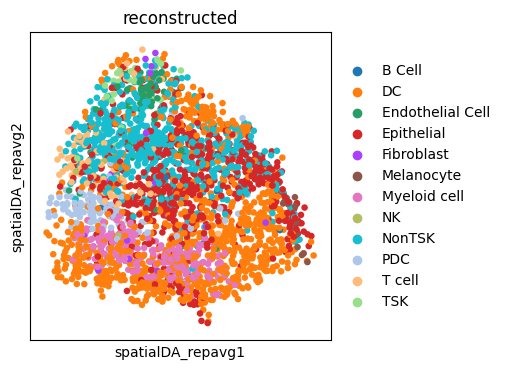

In [68]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
sc.pl.spatial(scadata,color="rough_celltype",spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',save='AllP2')
#save='allreconstructed'

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'rough_celltype' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


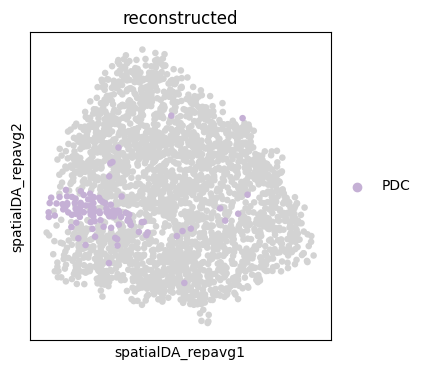

In [18]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
sc.pl.spatial(scadata,color="level2_celltype",groups=["PDC"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


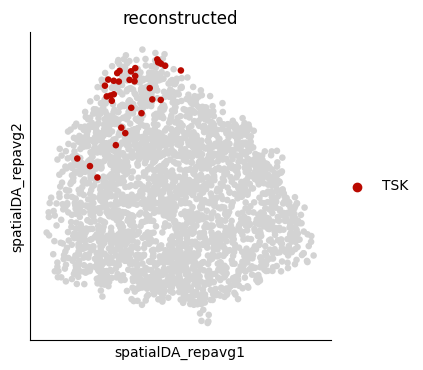

In [35]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
sc.pl.spatial(scadata,color="level3_celltype",groups=["TSK"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P2TSK')
#save='TSK',

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


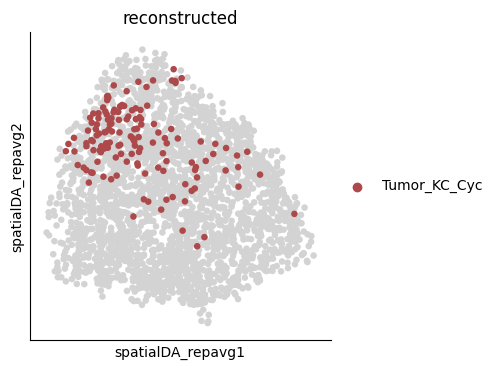

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


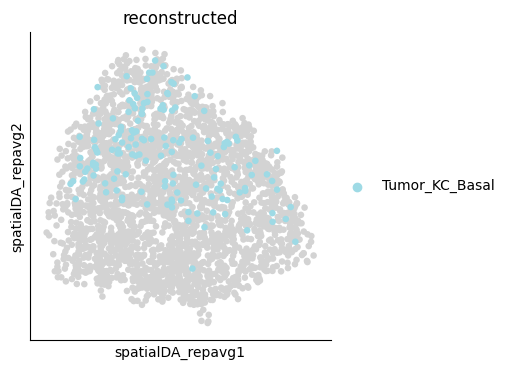

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


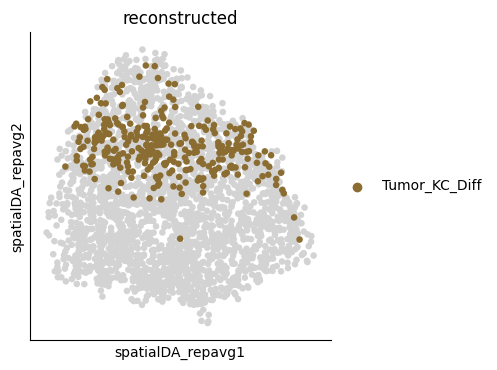

In [38]:
figsize(4,4)
sc.pl.spatial(scadata,color="level2_celltype",groups=["Tumor_KC_Cyc"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P2cyc')
sc.pl.spatial(scadata,color="level2_celltype",groups=["Tumor_KC_Basal"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P2bas')
sc.pl.spatial(scadata,color="level2_celltype",groups=["Tumor_KC_Diff"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P2diff')
#save='nonTSK',

In [57]:
import squidpy as sq
sq.gr.spatial_neighbors(scadata,spatial_key='spatialDA_repavg')
sq.gr.nhood_enrichment(scadata,cluster_key='rough_celltype')
sq.gr.interaction_matrix(scadata,cluster_key='rough_celltype')

  0%|          | 0/1000 [00:00<?, ?/s]

In [58]:
kscadata = scadata[ scadata.obs.level2_celltype.isin(['Tumor_KC_Cyc','Tumor_KC_Basal','Tumor_KC_Diff','TSK'])].copy()
sq.gr.spatial_neighbors(kscadata,spatial_key='spatialDA_repavg')
sq.gr.nhood_enrichment(kscadata,cluster_key='level2_celltype')

  0%|          | 0/1000 [00:00<?, ?/s]

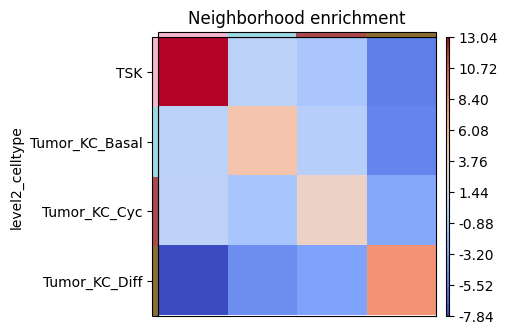

In [66]:
sq.pl.nhood_enrichment(kscadata, cluster_key="level2_celltype",cmap='coolwarm',save='TSKKC.pdf',figsize=(3,5))
plt.savefig('../result_TSK/TSKKC.pdf',bbox_inches='tight')

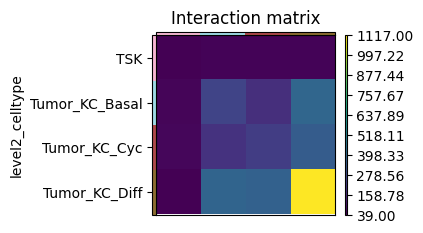

In [213]:
sq.gr.interaction_matrix(kscadata, cluster_key="level2_celltype")
sq.pl.interaction_matrix(kscadata, cluster_key="level2_celltype")

In [19]:
rawstdata = sc.read_csv('cSCC/GSM4284316_P2_ST_rep1_stdata.tsv.gz',delimiter='\t')
coord = np.array([x.split('x') for x in rawstdata.obs_names.tolist()],dtype='int')
rawstdata.obsm['spatial'] = coord

rawstmeta = pd.read_csv('cSCC/GSM4284316_spot_data-selection-P2_ST_rep1.tsv.gz',delimiter='\t')
stindex=[]
for i in range(len(rawstmeta.x.tolist())):
    stindex.append(str(rawstmeta.x[i])+'x'+str(rawstmeta.y[i]))
rawstmeta.index = stindex

rawstdata = rawstdata[stindex,:]
rawstdata.obs = rawstmeta

sc.pp.normalize_total(rawstdata)
sc.pp.log1p(rawstdata)
rawstdata.raw= rawstdata
sc.pp.scale(rawstdata)

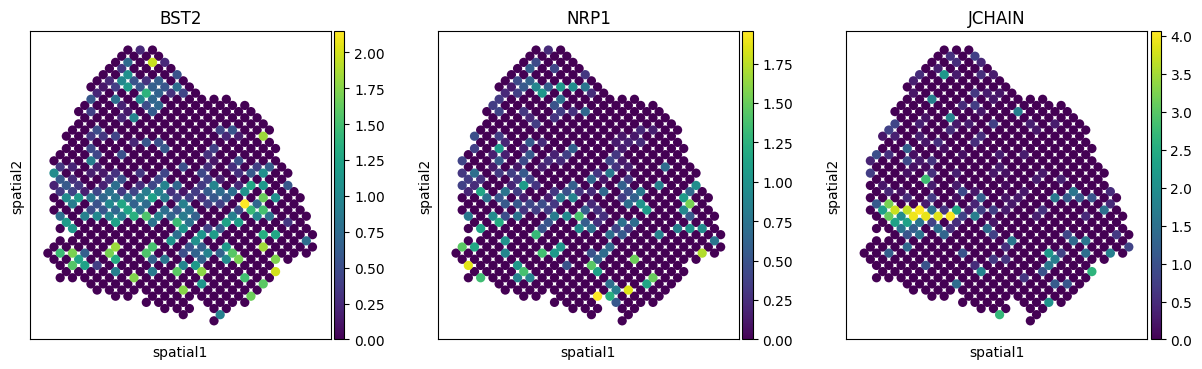

In [20]:
sc.pl.spatial(rawstdata,color=['BST2','NRP1','JCHAIN'],show=True,basis='spatial',na_in_legend=False,spot_size=1.5)

In [25]:
import seaborn as sns

In [29]:
sccooravg = scadata.obsm['spatialDA_rep1']
PDCcoor = sccooravg[scadata.obs.level2_celltype=='PDC',:]

In [30]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(rawstdata.obsm['spatial'])
nearST = nbrs.kneighbors(PDCcoor,return_distance=False)
nearST = list(set(nearST.flatten()))

rawstdata.obs['pDCnear'] = 'Others'
rawstdata.obs.iloc[nearST,-1]='pDC'

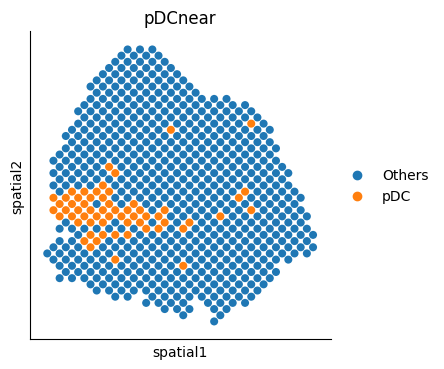

In [34]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(rawstdata,color=['pDCnear'],show=True,basis='spatial',na_in_legend=False,spot_size=1.3,save='pDCenrich')

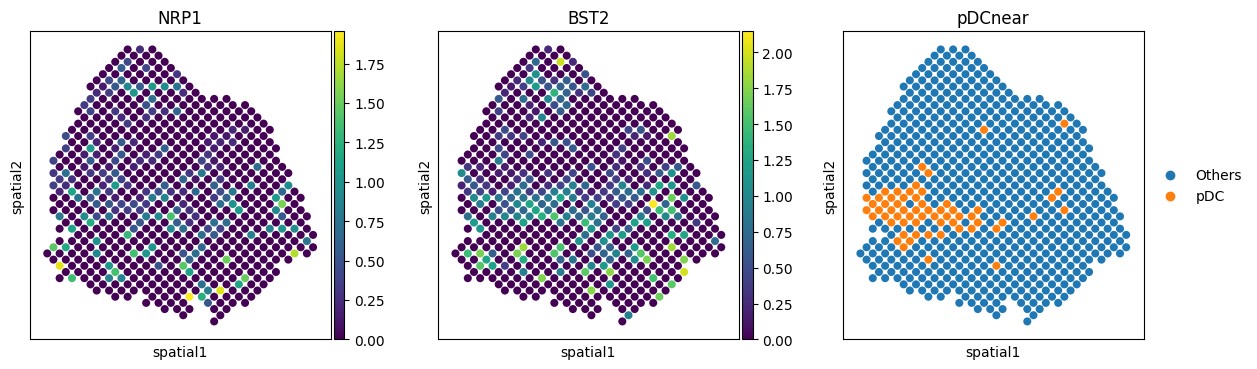

In [32]:
figsize(4,4)
sc.pl.spatial(rawstdata,color=['NRP1','BST2','pDCnear'],show=True,basis='spatial',na_in_legend=False,spot_size=1.3)

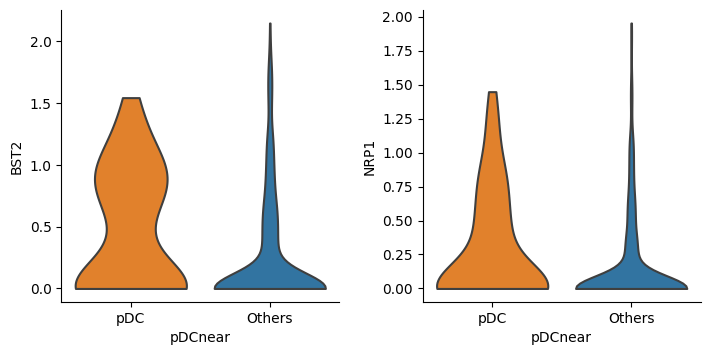

In [79]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.settings.figdir='./revise/'
fig = sc.pl.violin(rawstdata,['BST2','NRP1'],groupby='pDCnear',size=0,multi_panel=True,order =['pDC','Others'],use_raw=True,save='pDCmarkergene')

In [80]:
sc.tl.rank_genes_groups(rawstdata,groupby='pDCnear')
degdf = sc.get.rank_genes_groups_df(rawstdata,group='pDC',log2fc_min=0)
degdf.loc[degdf.names.isin(['BST2','NRP1']),:]

,names,scores,logfoldchanges,pvals,pvals_adj
193,BST2,3.409214,1.118317,0.001094,0.028224
517,NRP1,2.441223,0.976296,0.017277,0.174690


In [82]:
strep3adata = sc.read_h5ad('cSCC/processed/stP2rep3.h5ad')

sc.pp.normalize_total(strep3adata)
sc.pp.log1p(strep3adata)

testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(strep3adata.X,dtype=torch.float32).cuda())

# netst2sc = F.normalize(torch.exp(scembedding.mm(stembedding.t())),p=1,dim=1).detach().cpu().numpy()
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=strep3adata.obs_names,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=strep3adata.obs_names)

spcoor = pd.DataFrame(strep3adata.obsm['spatial'],index=strep3adata.obs_names,columns=['xcoord','ycoord'])

rep_coord = all_coord(netsc2st,spcoor)

scadata.obsm['spatialDA_rep3']  = rep_coord

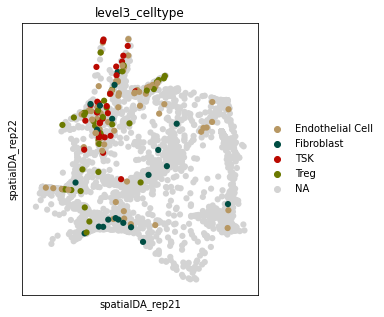

In [84]:
sc.pl.spatial(scadata,color="level3_celltype",groups=["TSK", "Treg", "Fibroblast",'Endothelial Cell'],spot_size=1,basis='spatialDA_rep2')

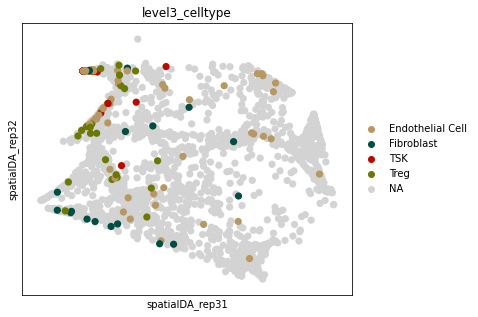

In [85]:
sc.pl.spatial(scadata,color="level3_celltype",groups=["TSK", "Treg", "Fibroblast",'Endothelial Cell'],spot_size=1,basis='spatialDA_rep3')